**Predict 30-day hospital readmission**

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
%matplotlib inline
plt.style.use('ggplot') 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

**Load Data from hugging face**

@article{zhao2023large,
  title={A large-scale dataset of patient summaries for retrieval-based clinical decision support systems},
  author={Zhao, Zhengyun and Jin, Qiao and Chen, Fangyuan and Peng, Tuorui and Yu, Sheng},
  journal={Scientific Data},
  volume={10},
  number={1},
  pages={909},
  year={2023},
  publisher={Nature Publishing Group UK London}
}

In [17]:
import pandas as pd

df = pd.read_csv("hf://datasets/zhengyun21/PMC-Patients/PMC-Patients.csv")

In [3]:
print(df.head())

   patient_id patient_uid      PMID                         file_path  \
0           0   7665777-1  33492400  comm/PMC007xxxxxx/PMC7665777.xml   
1           1   7665777-2  33492400  comm/PMC007xxxxxx/PMC7665777.xml   
2           2   7665777-3  33492400  comm/PMC007xxxxxx/PMC7665777.xml   
3           3   7665777-4  33492400  comm/PMC007xxxxxx/PMC7665777.xml   
4           4   7665777-5  33492400  comm/PMC007xxxxxx/PMC7665777.xml   

                                               title  \
0  Early Physical Therapist Interventions for Pat...   
1  Early Physical Therapist Interventions for Pat...   
2  Early Physical Therapist Interventions for Pat...   
3  Early Physical Therapist Interventions for Pat...   
4  Early Physical Therapist Interventions for Pat...   

                                             patient               age gender  \
0  This 60-year-old male was hospitalized due to ...  [[60.0, 'year']]      M   
1  A 39-year-old man was hospitalized due to an i...  [[39.0, 

In [9]:
print(df['title'].unique())

['Early Physical Therapist Interventions for Patients With COVID-19 in the Acute Care Hospital: A Case Report Series'
 'Deranged Liver Function Tests and Liver Insults in Malnourished Patients: A Report of Two Cases and Literature Review'
 'Goserelin Ovarian Ablation Failure in Premenopausal Women With Breast Cancer'
 ...
 'Heart of the Matter: Syncope as a Rare Presentation of Lung Cancer Invading\\nthe Heart'
 'A multidisciplinary collaborative model based on single-port\\nthoracoscopy for the treatment of giant mediastinal lymph node hyperplasia: a\\ncase report'
 'Resection of small acoustic neuroma using the transcanal transvestibular\\nendoscopic approach']


In [4]:
df_subset=df[:100]

**Implementing generic Clinical BERT model (assuming no labels)**

Kexin Huang, Jaan Altosaar, and Rajesh Ranganath. 2020. ClinicalBERT:
Modeling Clinical Notes and Predicting Hospital Readmission. In CHIL ’20:
ACM Conference on Health, Inference, and Learning; Workshop Track. April
02–04, 2020, Toronto, ON. ACM, New York, NY, USA, 9 pages.

In [5]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
model = AutoModelForSequenceClassification.from_pretrained("medicalai/ClinicalBERT")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Tokenize each patient note in the column
df_subset['tokens'] = df_subset['patient'].apply(lambda note: tokenizer.tokenize(note))

# Display the tokens for the first few rows
print(df_subset[['patient', 'tokens']].head())

                                             patient  \
0  This 60-year-old male was hospitalized due to ...   
1  A 39-year-old man was hospitalized due to an i...   
2  One week after a positive COVID-19 result this...   
3  This 69-year-old male was admitted to the ICU ...   
4  This 57-year-old male was admitted to the ICU ...   

                                              tokens  
0  [this, 60, -, year, -, old, male, was, hospita...  
1  [a, 39, -, year, -, old, man, was, hospital, #...  
2  [one, week, after, a, positive, co, ##vid, -, ...  
3  [this, 69, -, year, -, old, male, was, admitte...  
4  [this, 57, -, year, -, old, male, was, admitte...  


C:\Users\sukri\AppData\Local\Temp\ipykernel_23924\2257612256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['tokens'] = df_subset['patient'].apply(lambda note: tokenizer.tokenize(note))


In [7]:
# Define a function to predict the readmission risk score for each patient note
def predict_risk(patient_note):
    # Tokenize the input text (note)
    inputs = tokenizer(patient_note, return_tensors="pt", truncation=True, padding=True, max_length=512)
    #print(f"Tokenized Input Length: {len(inputs['input_ids'][0])}")  # Debugging

    # Make prediction (forward pass through the model)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Apply sigmoid for a binary classification score (risk score)
    risk_score = torch.sigmoid(logits[:,1]).item()  # Get the probability as a score #he risk of readmission (class 1).
    #print(f"Logits: {logits}, Risk Score: {risk_score}")  # Debugging
    return risk_score

# Apply the function to the 'patient_note' column and create a new 'readmission_risk' column
df_subset.loc[:, 'readmission_risk'] = df_subset['patient'].apply(predict_risk)

# Display the dataframe with risk scores
print(df_subset[['patient', 'readmission_risk']].head())

                                             patient  readmission_risk
0  This 60-year-old male was hospitalized due to ...          0.515559
1  A 39-year-old man was hospitalized due to an i...          0.515285
2  One week after a positive COVID-19 result this...          0.516732
3  This 69-year-old male was admitted to the ICU ...          0.517032
4  This 57-year-old male was admitted to the ICU ...          0.515975


C:\Users\sukri\AppData\Local\Temp\ipykernel_23924\3107095089.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'readmission_risk'] = df_subset['patient'].apply(predict_risk)


**The readmission risk seems to be clustered towards 50 to 51% which seems a bit odd. Although the pretrained model preprocesses and tokenizes  automatically, let's try to pre-process bt removing stop words and special characters and see if that makes a dufference**

**Perform basic preprocessing and tokenization**

In [19]:
import re
from nltk.corpus import stopwords
import nltk
from transformers import AutoTokenizer

# Download NLTK stopwords if not already available
nltk.download('stopwords')

# Load the pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")

# Define a function for preprocessing
def preprocess_text(text):
    # Remove special symbols (e.g., "-" but keep medical context terms like "COVID-19")
    text = re.sub(r"[^a-zA-Z0-9\s\-]", "", text)  # Retain "-" for medical terms

    # Tokenize words for stopword filtering
    stop_words = set(stopwords.words("english"))
    tokens = text.split()  # Split by space for stopword removal
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Rejoin tokens into a cleaned text
    return " ".join(filtered_tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sukri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# Add a column with preprocessed text
df_subset['preprocessed_text'] = df_subset['patient'].apply(preprocess_text)

# Check the DataFrame with preprocessed text
print(df_subset[['patient', 'preprocessed_text']])


                                              patient  \
0   This 60-year-old male was hospitalized due to ...   
1   A 39-year-old man was hospitalized due to an i...   
2   One week after a positive COVID-19 result this...   
3   This 69-year-old male was admitted to the ICU ...   
4   This 57-year-old male was admitted to the ICU ...   
..                                                ...   
95  Case 1 was a 2-year-old boy who was admitted t...   
96  Case 2 was a 1-year-old girl who presented wit...   
97  Lastly, case 3 was a 2-year-old boy who presen...   
98  A 20-day-old girl was admitted to the neonatal...   
99  A 75-year-old Caucasian woman with a history o...   

                                    preprocessed_text  
0   60-year-old male hospitalized due moderate ARD...  
1   39-year-old man hospitalized due increasingly ...  
2   One week positive COVID-19 result 57-year-old ...  
3   69-year-old male admitted ICU dry cough 2 week...  
4   57-year-old male admitted ICU d

In [21]:
# Apply tokenization function to the preprocessed_text column
df_subset['tokenized_inputs'] = df_subset['preprocessed_text'].apply(lambda note: tokenizer.tokenize(note))

# Check the results
print(df_subset[['preprocessed_text', 'tokenized_inputs']])


                                    preprocessed_text  \
0   60-year-old male hospitalized due moderate ARD...   
1   39-year-old man hospitalized due increasingly ...   
2   One week positive COVID-19 result 57-year-old ...   
3   69-year-old male admitted ICU dry cough 2 week...   
4   57-year-old male admitted ICU dyspnea heavy dr...   
..                                                ...   
95  Case 1 2-year-old boy admitted department hema...   
96  Case 2 1-year-old girl presented recurrent hem...   
97  Lastly case 3 2-year-old boy presented hemopty...   
98  20-day-old girl admitted neonatal intensive ca...   
99  75-year-old Caucasian woman history well-contr...   

                                     tokenized_inputs  
0   [60, -, year, -, old, male, hospital, ##ized, ...  
1   [39, -, year, -, old, man, hospital, ##ized, d...  
2   [one, week, positive, co, ##vid, -, 19, result...  
3   [69, -, year, -, old, male, admitted, i, ##cu,...  
4   [57, -, year, -, old, male, adm

**This seems to yield cleaner tokens but let's see if that makes a difference in the readmission risk scores.**

In [25]:
# Apply the function to the 'patient_note' column and create a new 'readmission_risk' column
df_subset.loc[:, 'readmission_risk'] = df_subset['preprocessed_text'].apply(predict_risk)

# Display the dataframe with risk scores
print(df_subset[['preprocessed_text', 'readmission_risk']].head())

                                   preprocessed_text  readmission_risk
0  60-year-old male hospitalized due moderate ARD...          0.514184
1  39-year-old man hospitalized due increasingly ...          0.514827
2  One week positive COVID-19 result 57-year-old ...          0.515701
3  69-year-old male admitted ICU dry cough 2 week...          0.515673
4  57-year-old male admitted ICU dyspnea heavy dr...          0.514303


**Pre-processing text separately did not improve the scores either.**

**Splitting data method**

In [26]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df_subset, test_size=0.2, random_state=42)

# Define a function to predict the readmission risk score for each patient note
def predict_risk(patient_note):
    # Tokenize the input text (note)
    inputs = tokenizer(patient_note, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Make prediction (forward pass through the model)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Apply sigmoid for a binary classification score (risk score)
    risk_score = torch.sigmoid(logits[:, 1]).item()  # Get the probability as a score
    return risk_score

# Apply the prediction function to the test set
test_df['readmission_risk'] = test_df['patient'].apply(predict_risk)

# Display the test dataframe with risk scores
print(test_df[['patient', 'readmission_risk']].head())


                                              patient  readmission_risk
83  A 40-year-old male engineer, former profession...          0.518061
53  Patient 2: A 43-year-old woman with subarachno...          0.516854
70  The first patient is a 53-year-old male with a...          0.518214
45  A 44-year-old female with a history of asthma,...          0.520647
44  A 68-year-old female patient was admitted to t...          0.518904


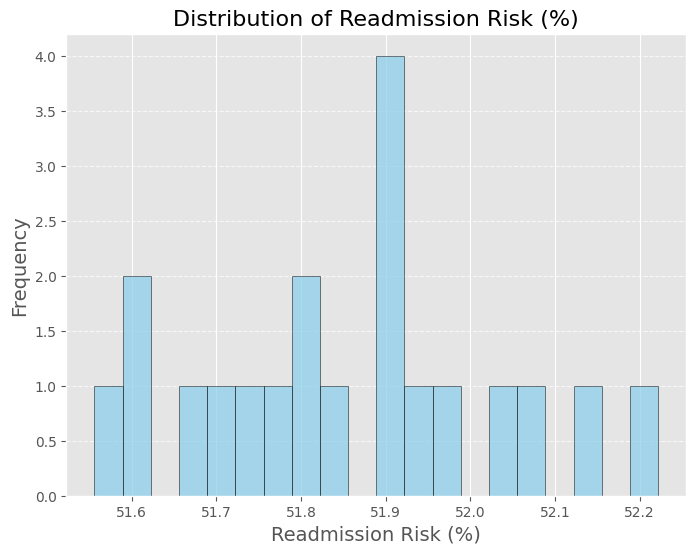

In [27]:
import matplotlib.pyplot as plt

# Convert readmission risk to percentage
test_df['readmission_risk_percent'] = test_df['readmission_risk'] * 100

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(test_df['readmission_risk_percent'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Readmission Risk (%)', fontsize=16)
plt.xlabel('Readmission Risk (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Splitting data into train and test method did not yield any improvement. Thus, in order to produce more accurate predictions, we need to either have labeled dataset and/or fine-tune the model experimenting with various parameters.**


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",  # where to save the model
    num_train_epochs=3,      # number of training epochs
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,  # pretrained model
    args=training_args,
    train_dataset=train_dataset,  # your training data
    eval_dataset=eval_dataset,    # your validation data
)

trainer.train()


In [ ]:
from transformers import get_scheduler

# Scheduler for learning rate adjustment
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Training Loop
model.train()
for epoch in range(3):  # Number of epochs
    for batch in train_loader:
        # Move data to device
        batch = {key: val.to(device) for key, val in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
    print(f"Epoch {epoch + 1} completed.")


**Evaluate the model**

In [ ]:
from sklearn.metrics import accuracy_score

model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Validation Accuracy: {accuracy:.4f}")


In [ ]:
model.save_pretrained('./clinicalbert_readmission_classifier')
tokenizer.save_pretrained('./clinicalbert_readmission_classifier')


**Method 2 assuming no labels - zero-shot classifier**

In [28]:
from transformers import pipeline

# Load zero-shot classifier pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define possible categories (labels)
labels = ["high risk", "low risk"]

# Example clinical note (your dataset will contain these notes)
note = "Patient is recovering well post-surgery, but there are concerns about complications."

# Predict the category
result = classifier(note, candidate_labels=labels)

# Output prediction
print(result)


{'sequence': 'Patient is recovering well post-surgery, but there are concerns about complications.', 'labels': ['high risk', 'low risk'], 'scores': [0.9266192317008972, 0.0733807310461998]}
